# Aircraft Conceptual Design: A Data Science Approach



---



---


**This piece illustrates the types of questions I ask myself on a day-to-day basis, and is intended as an informal exploration and in no way any serious engineering or technical advice. This is just me having fun with ideas, and bringing whoever reads this along for the ride. **


---



---





>>>>>>>>That being said...

##The Preamble
When performing a trade study of aircraft for conceptual designs, statistical approaches and ingenuity have been the primary component. However, the traditional statistical approaches rely heavily on patterns which human beings are able to recognize and interpret. What about a machine's interpretation of data? I, a lowly aerospace engineering student, will explore how modern technologies such as machine learning algorithms (deep artificial neural networks, especially) interpret patterns in the data they're given, and answer a question that's been on my mind:
>>>>>>*What if there was an AI to design aircraft?*

Obviously I'm no machine learning Ph.D, nor do I claim to be an aerospace engineer (only a student). I get curious nonetheless, and figured why not experiment; "See what we can see," as an old math prof of mine would say. 
##The Problem Given
With a certain set of requirements, such as mission-specific parameters, design an air taxi to satisfy all requirements, potentially optimizing for a specific subset of paramters, which are emphasized by the problem itself (i.e. safety, cost, efficiency, speed, fuel cost).
The requirements are given below:

Criteria | Requirements
---|---
Maximum take-off weight (MTOW) as per FAR 23 | 19,000 lbs (8597 kg)
Reference mission |  • 50% passenger weight
|• Warm up and taxi
|• Take-off
|• Climb
|• Cruise
|• Descend to sea level
|• Land with sufficient fuel left to:
|o Climb
|o loiter for 45 min
|o descend
|o land
|• Average cruise speed ≥ 180 kts
|• Total range of ≥135 nm
Long range sizing mission | • Full payload weight
|• Take-off and land as for Reference mission
|• Cruise for 250 nmi
|• Reserve as for Reference Mission
Service ceiling | • At least 7620 m (25,000 ft)
Engine(s) | • Single or twin turbofan or turboprop
|• If using reciprocating engines (e.g. piston) then 
|you must have two engines or incorporate a full 
|aircraft parachute into your design
Take-off field length | • Takeoff over a 15 m (50 ft) obstacle in
|less than 750 m (2500 ft)
Landing field length | • 750 m (2500 ft) at MTOW
Additional requirements | • Must be equipped with anti-icing and deicing capabilities for 
|Canadian operations

That problem statement is beautiful: Short, to the point, and almost all of them have numbers in them. Just what machine learning algorithms like. With the problem statement, it's time to outline the...
##The Data Science Approach


1.   Extract data from a main database, being the online Aircraft Bluebook in this case
2.   Given the raw data, extract and encode all information into numerical representations of each parameter
3. With the cleaned data, create visualizations to help decide how patterns in the parameters might exist
4. Based on the data, select a model(s) that best captures the behaviour of the data 
5. Compare models, evaluate trends in modelling accuracy
6. Potentially tweak parameters and architectures to get a better model 

##1. Data Extraction
First, go to the Aircraft Bluebook website and download all the data on their fixed-wing aircraft

In [0]:
#Import all modules needed
from bs4 import BeautifulSoup
from requests import get 
import pandas as pd
import re
import warnings
warnings.filterwarnings("ignore")

#Use beautifulsoup to scrape web data
soup = BeautifulSoup(get('https://aircraftbluebook.com/Tools/ABB/ShowSpecifications.do').text, 'html.parser')
souper = soup.find_all('thead') #where the table header is 
plane_index = souper[0] #The specific table for aircraft
head = plane_index.text.split('\n')[2:-2] #Cleaning the blank entries
header = [str(value) for value in head] #Converting to string

souper = soup.find_all('tbody') #Looking for the raw data
dataset = souper[0] #Using the data for aircraft

x = [] #the data will be stored here
for row in dataset.find_all('tr'): #Chunking through the html table in order to grab the necessary data
    temp = row.find_all('td')
    textlist = [] #The list of properties for every row in the table
    i =0 #Used initially for skipping data that's meant to be strings (name, engine type)
    for s in temp:
        if i <2 : # Where the strings live in each row
            textlist.append(str(s.text))
        else: 
            textlist.append( re.sub("[^0-9]", "", str(s.text).replace('/','.'))) #Some numerical properties have things like whether or not the aircraft is wet or dry, which isn't needed and not frequent in the data
        i+=1 #Updating the index
    if len(textlist) == 21: #Some rows in the table have single entries for the aircraft company, which isn't needed
        
        x.append(textlist)
airframe = pd.DataFrame(data = x) #Create a dataframe for some descriptive statistics
airframe.columns = head #Using the column labels from the table from the website
airframe.head() #Show what the table is looking like



,Model,Engine Type,HP or lbs thr ea engine,Max speed Knots,Rcmnd cruise Knots,Stall Knots dirty,Fuel gal/lbs,All eng service ceiling,Eng out service ceiling,All eng rate of climb,...,Takeoff over 50ft,Takeoff ground run,Landing over 50ft,Landing ground roll,Gross weight lbs,Empty weight lbs,Length ft/in,Height ft/in,Wing span ft/in,Range N.M.
0,15 AC Sedan,Piston,145,104,91,46,36,13000,,450,...,900,,1300,,2050,1180,253,103,375,370
1,11 CC Super Chief,Piston,85,89,83,44,15,12300,,600,...,720,,800,,1350,820,207,89,361,190
2,7 CCM Champ,Piston,90,90,78,37,19,16000,,650,...,475,,850,,1300,810,215,87,350,210
3,7 DC Champ,Piston,85,88,78,37,19,13000,,620,...,500,,850,,1300,800,215,87,350,210
4,7 AC Champ,Piston,65,83,74,33,14,12500,,370,...,632,,885,,1220,740,215,89,350,175


Looks like everything got scraped successfully. Now, it is time to numericize the engine types so that algorithms can factor in the engine type as well. Since this is the first question I want to answer, I need to make sure the engine datatypes are in the right form. 

##2. Cleaning Data

With the data gathered, it's time for some cleaning. Namely, re-labeling the engine types to numerical codes. That way, any descriptive statistics can give an average, and any model using the engine types as labels can do just that.

       Engine Type  HP or lbs thr ea engine  Rcmnd cruise Knots  \
count   588.000000               588.000000          588.000000   
mean      1.319728               757.340136          194.365646   
std       0.662825              1628.358739           97.980636   
min       1.000000                65.000000           65.000000   
25%       1.000000               188.750000          130.750000   
50%       1.000000               260.000000          168.500000   
75%       1.000000               380.000000          216.250000   
max       3.000000             13850.000000          511.000000   

       All eng service ceiling  All eng rate of climb  Takeoff over 50ft  \
count               588.000000             588.000000         588.000000   
mean              22813.340136            1613.137755        1945.234694   
std                9608.472511            1328.154042        1069.280482   
min                 850.000000             360.000000         350.000000   
25%             

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faaf45b0358>,
      dtype=object)

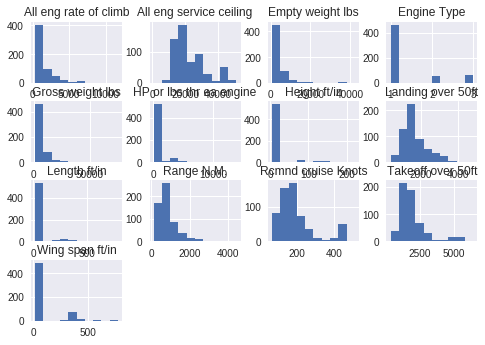

In [0]:
thrusts = set(airframe['Engine Type']) #Get all listed engine types

#Turns out there are some typos in the labels, but that is easily fixed
airframe = airframe.replace(['Piston','Pistion','piston'],1)
airframe = airframe.replace(['Propjet'],2)
airframe = airframe.replace(['Jet'],3)
airframe = airframe.replace(['', 'PT6A-21','IO550','PT6A-35','TSIO 520'],0)

#Get rid of some redundant properties
condensed = airframe.drop(['Max speed Knots', 'Stall Knots dirty','Fuel gal/lbs', 'Eng out service ceiling','Eng out rate of climb', 'Takeoff ground run', 'Landing ground roll'], axis = 1)
#Making a list of the condensed column names
connames = list(condensed.columns.values)

#Chunking through the data and converting the numerical values to floats (from strings)
for entry in connames[1:]:
    condensed[entry] = condensed[entry].astype(float)
for entry in connames[-4:-1]: #Modifying the annotations in the last set of columns by converting to the correct dimensions
    condensed[entry] /= 10
for state in list(condensed.columns.values)[1:]:
  
  condensed = condensed[condensed[state] > 0]
print(condensed.describe()) #Time for some descriptive statistics
condensed.hist()#Get some example histograms

##3. Simple Modelling
Now, perform a principal component analysis to reduce the dimensionality of the data to two dimensions for visualization. Similarly, the tSNE algorithm will be used to also visualize the data in two dimensions. 

(588,)
(588, 2)
PCA
t-SNE


<Figure size 576x396 with 0 Axes>

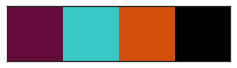

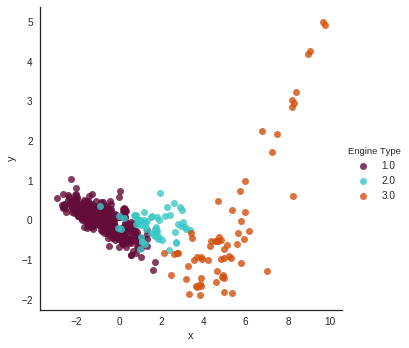

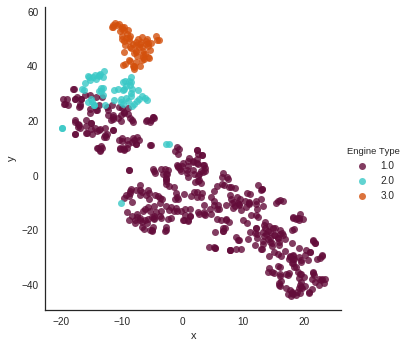

In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.manifold import TSNE

data_ = airframe.drop(['Model'], axis = 1)


def PCAPlt(condensed,graphing):
  features = ['Rcmnd cruise Knots','All eng service ceiling','Takeoff over 50ft','Landing over 50ft','Gross weight lbs','Range N.M.']
  
  #______________PCA MODEL
  plt.figure(1)
  #Plotting setup
  sb.set_style('white')
  customPalette = ['#630C3A', '#39C8C6', '#D3500C','#000000']
  sb.set_palette(customPalette)
  sb.palplot(customPalette)

  #scaling and fitting data
  airscaler = StandardScaler()
  air_norm = airscaler.fit(graphing[features])
  air_std = air_norm.transform(graphing[features])
  pca = PCA(n_components=2)
  pca.fit(airscaler.transform(condensed[features]))
  air2d = pca.transform(air_std)
  tsne = TSNE(n_components = 2)
  tsne.fit(airscaler.transform(condensed[features]))
  air2d2 = tsne.fit_transform(air_std)

  #Concatenating data with labels
  labels = graphing['Engine Type']
  print(labels.shape)
  data = pd.DataFrame(air2d, columns = ['x','y'], index=labels.index)
  data2 = pd.DataFrame(air2d2, columns = ['x','y'], index=labels.index)
  print(data.shape)
  data = pd.concat([data,labels], axis = 1)
  data2 = pd.concat([data2, labels], axis = 1)

  #Plotting 
  print("PCA")
  facet = sb.lmplot(data=data, x='x',y='y', hue = 'Engine Type',fit_reg=False, legend=True, legend_out=True)
  print("t-SNE")
  facet2 = sb.lmplot(data=data2, x='x',y='y', hue = 'Engine Type',fit_reg=False, legend=True, legend_out=True)

  return
PCAPlt(condensed,condensed)

##4,5,6: Genetic Algorithms
Looks like the data could be potentially clustered based on engine type. This is a good sign because it means that there is potentially a machine learning model out there that is able to figure out which engine type to use for the requirements. However, the data overlaps a bit, which adds to the complexity of the problem. Since a solution isn't immediately apparent, there is always the option of using [tree-based] **genetic algorithms** to figure out which model will best describe the data. The whole model selection, testing, and tweaking is automated by the genetic algorithms' evolution. All that has to be done is to feed it data, and it will spit out a jewel of a model... Ideally.

In [0]:
#Import the libraries
!pip install tpot xgboost #Speed up the process
from tpot import TPOTClassifier #Using the TPOT library
import numpy as np

x = data_[['Rcmnd cruise Knots','All eng service ceiling','Takeoff over 50ft','Landing over 50ft','Gross weight lbs','Range N.M.']] #Using features that the mission requirements outline
y = data_[['Engine Type']] #The label is engine type, since that's what is trying to be figured out

X = np.array(StandardScaler().fit_transform(x)) #Scaling the data for better modeling
Y = np.array(y) #this block separate from the TPOT fit below, so that this cell can declare variables without waiting for TPOT to finish

In [0]:
tpot = TPOTClassifier(generations=6, verbosity=2)
tpot.fit(X, Y)
print(tpot.score(X,Y))




Optimization Progress:  29%|██▊       | 200/700 [01:51<07:40,  1.09pipeline/s]

Generation 1 - Current best internal CV score: 0.9526409846773609


Optimization Progress:  43%|████▎     | 300/700 [03:39<04:58,  1.34pipeline/s]

Generation 2 - Current best internal CV score: 0.9551088605371929


Optimization Progress:  57%|█████▋    | 400/700 [06:02<06:12,  1.24s/pipeline]

Generation 3 - Current best internal CV score: 0.9551088605371929


Optimization Progress:  71%|███████▏  | 500/700 [07:56<02:56,  1.13pipeline/s]

Generation 4 - Current best internal CV score: 0.9574308662340141


Optimization Progress:  86%|████████▌ | 600/700 [09:33<00:57,  1.73pipeline/s]

Generation 5 - Current best internal CV score: 0.9574308662340141


Generation 6 - Current best internal CV score: 0.9574308662340141

Best pipeline: ExtraTreesClassifier(SelectPercentile(input_matrix, percentile=53), bootstrap=False, criterion=gini, max_features=0.9500000000000001, min_samples_leaf=2, min_samples_split=20, n_estimators=100)
0.9780487804878049


Looks good! Now, let's try the suggested model on the mission requirements to see which engine should be used. The approach here is to vary the parameters for a certain range, given that the initial requirements are only maxima/minima, and improvements upon the requirements aren't outside the realm of possibility. Therefore, it might be a good idea to explore an *area* of the subspace to see how much the results change.

In [0]:
from sklearn.ensemble import ExtraTreesClassifier #Using the suggested classifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_selection import SelectPercentile
from sklearn.pipeline import make_pipeline

#Creating a data pipeline based on what TPOT suggested

pipe = make_pipeline(
  MaxAbsScaler(),
  SelectPercentile(percentile = 53)  ,
  ExtraTreesClassifier(bootstrap=False, criterion='gini', max_features=0.9500000000000001, min_samples_leaf=2, min_samples_split=20, n_estimators=100)

)
pipe.fit(x,y)


#Iterating through the space to consider nearby possibilities, as well as to perform a model-sensitivity analysis

def missions(classifier):
  projections = []
  for i in range(5): #Getting 5 samples within each subspace of requirements, varying each point independently
    for j in range(5):
      for k in range(5):
        for l in range(5):
          for m in range(5):
            requirements = np.array([180+24*i,25000+1000*j, 750-90*k,750-90*k,7000-600*l,135+380*m]).reshape(1,-1)
            pred = classifier.predict(requirements)[0]
            projections.append([pred, 180+24*i,25000+1000*j, 750-90*k,750-90*k,7000-600*l,135+380*m])
  pro = pd.DataFrame(projections)
  conLabels = ['Engine Type','Rcmnd cruise Knots','All eng service ceiling','Takeoff over 50ft','Landing over 50ft','Gross weight lbs','Range N.M.']
  pro.columns = conLabels
  print(pro.describe())
  return
  
missions(pipe)

       Engine Type  Rcmnd cruise Knots  All eng service ceiling  \
count  3125.000000         3125.000000              3125.000000   
mean      1.072000          228.000000             27000.000000   
std       0.258529           33.946557              1414.439891   
min       1.000000          180.000000             25000.000000   
25%       1.000000          204.000000             26000.000000   
50%       1.000000          228.000000             27000.000000   
75%       1.000000          252.000000             28000.000000   
max       2.000000          276.000000             29000.000000   

       Takeoff over 50ft  Landing over 50ft  Gross weight lbs   Range N.M.  
count         3125.00000         3125.00000       3125.000000  3125.000000  
mean           570.00000          570.00000       5800.000000   895.000000  
std            127.29959          127.29959        848.663935   537.487159  
min            390.00000          390.00000       4600.000000   135.000000  
25%        

It turns out, in fact, that a variation of the parameters shows the model to be slightly sensitive in this region. Interesting. 

Also, referring to a classifier comparison, and taking a look at the PCA plot, there are a couple models that might also be tested to see what their predictions are, so that way the engine selection is based on a series of different model mechanics and evalutations. Observe the classifier 'methods'  in the photo below, [provided on the sklearn website](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html):

![alt text](https://scikit-learn.org/stable/_images/sphx_glr_plot_classifier_comparison_001.png)
##7. Making Sure
While the model suggested a piston engine in most cases, it would be good to double-check by plotting the mission requirements for some visual inspection. The new 'mystery engine,' class 4, will be a placeholder to make it easier to see where the mission falls.

(589,)
(589, 2)
PCA
t-SNE


<Figure size 576x396 with 0 Axes>

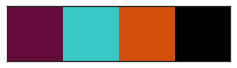

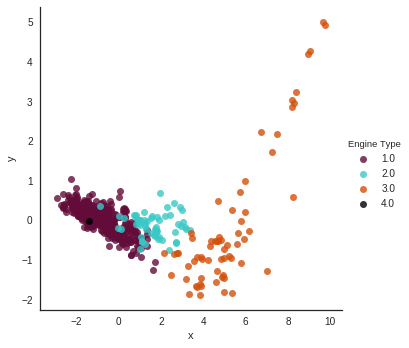

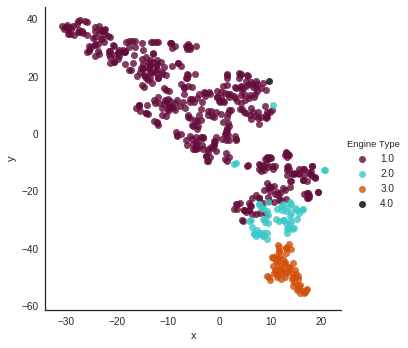

In [0]:
req = pd.DataFrame([[4, 180,25000, 750,750,7000,135]])
req.columns = ['Engine Type','Rcmnd cruise Knots','All eng service ceiling','Takeoff over 50ft','Landing over 50ft','Gross weight lbs','Range N.M.']
PCAPlt(condensed, pd.concat([condensed,req]))

With that black dot being the mission requirements, it looks like a piston engine might be the best prediction.

Better use a few different models to see what can be seen and compare. 

In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

def quickFit(x,y,np_reqs):
    engine_decoder = ['Piston', 'Turboprop', 'Jet'] #To take the prediction of each classifier and convert it to string
    classifiers = {
            "Nearest Neighbors": KNeighborsClassifier(10),
            "Linear SVM": SVC(kernel="linear", C=0.025),
            "RBF SVM": SVC(gamma=2, C=1),
            "Gaussian Process": GaussianProcessClassifier(1.0 * RBF(1.0)),
            "Decision Tree": DecisionTreeClassifier(max_depth=5),
            "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
            "Neural Net": MLPClassifier(alpha=1),
            "AdaBoost": AdaBoostClassifier(),
            "Naive Bayes": GaussianNB(),
            "QDA":QuadraticDiscriminantAnalysis()}
    classScore = []
    for model in classifiers.keys():
        classifiers[model].fit(x,y)
        print(model, ': ',engine_decoder[classifiers[model].predict(np_reqs)[0]-1])
        classScore.append(engine_decoder[classifiers[model].predict( np_reqs)[0]-1])
    return classScore
print(quickFit(x,y, np.array([180,25000, 750,750,7000,135]).reshape(1,-1)))




Nearest Neighbors :  Piston
Linear SVM :  Piston
RBF SVM :  Piston
Gaussian Process :  Turboprop
Decision Tree :  Piston
Random Forest :  Piston
Neural Net :  Piston
AdaBoost :  Piston
Naive Bayes :  Piston
QDA :  Piston
['Piston', 'Piston', 'Piston', 'Turboprop', 'Piston', 'Piston', 'Piston', 'Piston', 'Piston', 'Piston']


The average prediction is still piston. Interesting. Along with the models themselves, there is also the option of finding aircraft that would already satisfy the mission requirements, or at least come close. Just to check:

In [0]:
requirements = {'Rcmnd cruise Knots':180,'All eng service ceiling':25000, 'Takeoff over 50ft':750,'Landing over 50ft':750,'Gross weight lbs':7000,'Range N.M.':135}
req_keys = list(requirements.keys())

cruised = condensed[condensed['Rcmnd cruise Knots'] >= 180]
served = cruised[cruised['All eng service ceiling'] >= 25000]
takeoff = served[served['Takeoff over 50ft'] <= 750]
landing = takeoff[takeoff['Landing over 50ft'] <= 750]
gross = landing[landing['Gross weight lbs'] <= 19000]
ranged = gross[gross['Range N.M.'] >= 135]
print(ranged.describe())

       Engine Type  HP or lbs thr ea engine  Rcmnd cruise Knots  \
count          0.0                      0.0                 0.0   
mean           NaN                      NaN                 NaN   
std            NaN                      NaN                 NaN   
min            NaN                      NaN                 NaN   
25%            NaN                      NaN                 NaN   
50%            NaN                      NaN                 NaN   
75%            NaN                      NaN                 NaN   
max            NaN                      NaN                 NaN   

       All eng service ceiling  All eng rate of climb  Takeoff over 50ft  \
count                      0.0                    0.0                0.0   
mean                       NaN                    NaN                NaN   
std                        NaN                    NaN                NaN   
min                        NaN                    NaN                NaN   
25%             

Yikes, it turns out no aircraft satisfy any of the requirements.  All models considered, it would seem the best bet is a piston engine. However, what if I wanted to design an aircraft that was a bit better at what it's supposed to do? Using the same methods as before with 'better' requirements:

(589,)
(589, 2)
PCA
t-SNE
Nearest Neighbors :  Turboprop
Linear SVM :  Jet
RBF SVM :  Piston
Gaussian Process :  Turboprop
Decision Tree :  Turboprop
Random Forest :  Jet
Neural Net :  Turboprop
AdaBoost :  Turboprop
Naive Bayes :  Turboprop
QDA :  Turboprop
['Turboprop', 'Jet', 'Piston', 'Turboprop', 'Turboprop', 'Jet', 'Turboprop', 'Turboprop', 'Turboprop', 'Turboprop']
Genetic Algorithm:  Turboprop


<Figure size 576x396 with 0 Axes>

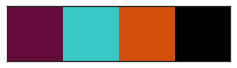

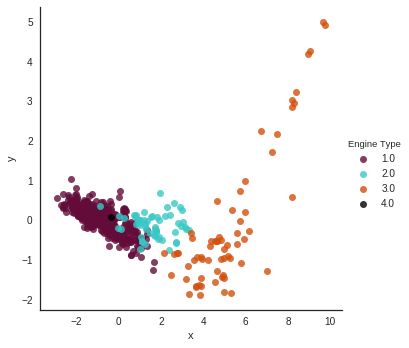

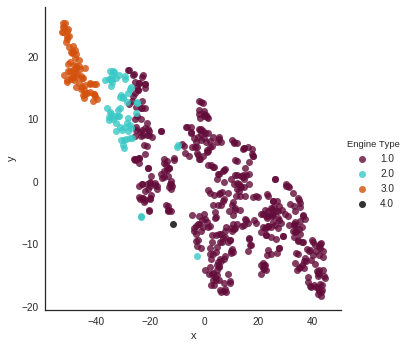

In [0]:
req = pd.DataFrame([[4,  1.5*180, 1.5*25000,  .5*750,.5*750,1.5*7000,5*135]])
req.columns = ['Engine Type','Rcmnd cruise Knots','All eng service ceiling','Takeoff over 50ft','Landing over 50ft','Gross weight lbs','Range N.M.']
PCAPlt(condensed, pd.concat([condensed,req]))
engine_decoder = ['Piston', 'Turboprop', 'Jet'] #Print prediction to string

print(quickFit(x,y, np.array([1.5*180, 1.5*25000,  .5*750,.5*750,1.5*7000,5*135]).reshape(1,-1)))
print("Genetic Algorithm: ",engine_decoder[pipe.predict(np.array([1.5*180, 1.5*25000,  .5*750,.5*750,1.5*7000,5*135]).reshape(1,-1))[0]-1])


Despite what the PCA and tSNE plots suggest, a quick analysis of the suggestions from different clustering algorithms gives back mostly a turboprop configuration. Consultation with a university aircraft design textbook led to the same design conclusion. 

# Conclusion
Given the unbiased process of data extraction, modelling, and statistical reasoning, an automation for dimensional analysis and prediction could potentially aid a designer in their statistically-based trade studies. 